<a href="https://colab.research.google.com/github/fedhere/MLPNS_FBianco/blob/main/linearRegression/FittingLineToGRBAfterglows_Fits_TrainTestSplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods. 

Notes: 

a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    
  **TL;DR: we measure a quantity named magnitude over time, which is an inverse logaritmic measure of brightness of the GRB, and which is expected to change it roughly linearly with the logarithm of time.**

_About GRB Afterglows_

*Gamma-ray bursts (GRBs) are bright X-ray and gamma-ray flashes observed in the sky, emitted by distant extragalactic sources. They are associated with the creation or merging of neutron stars or black holes; processes which result in an explosive outburst of material moving incredibly close to the speed of light [ref](https://www.mpg.de/16999277/0607-kern-gammarayburst-153865-x#:~:text=It%20was%20this%20afterglow%20emission,the%20form%20of%20synchrotron%20photons). Long after the initial burst of gamma rays has subsided, gamma ray bursts (GRBs) are still observable at less energetic wavelengths. Although no formal definition exists, this smoothly varying, lower energy radiation that may be visible for several days following the GRB itself, is usually referred to as the GRB afterglow.*


    
  **Details**: *The light that we measure from these explosions changes over time, so we can study its time series. The change in light is exponential, not linear, but if we take the logarithm of the light, that chance may be linear, since the logarithm is the inverse of exponent. The logarithm of the light flux is called magnitude in astronomy. A line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process.*
    
*It is believed that the afterglow originates in the external shock produced as the blast wave from the explosion collides with and sweeps up material in the surrounding interstellar medium. The emission is synchrotron emission produced when electrons are accelerated in the presence of a magnetic field. The successive afterglows at progressively lower wavelengths (X-ray, optical, radio) result naturally as the expanding shock wave sweeps up more and more material causing it to slow down and lose energy.*

*X-ray afterglows have been observed for all GRBs, but only about 50% of GRBs also exhibit afterglows at optical and radio wavelengths [ref](https://astronomy.swin.edu.au/cosmos/G/gamma+ray+burst+afterglow)*

# initial imports

In [ ]:
import pandas as pd
import pylab as pl
%pylab inline

import warnings
warnings.filterwarnings('ignore')

# I have created a stylesheet to define default plot behaviors. 
# This stylesheet changes the default parameters stored in the dictionary matplitlib.rcParams
pl.style.use("https://raw.githubusercontent.com/fedhere/MLPNS_FBianco/main/fbb.mplstyle")
pl.rcParams['font.size'] = 20

Populating the interactive namespace from numpy and matplotlib


# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

Find the link at [github.com/fedhere/MLPNS_FBianco/main/linearRegression](https://github.com/fedhere/MLPNS_FBianco/tree/main/linearRegression)

In [ ]:
url = "https://raw.githubusercontent.com/fedhere/MLPNS_FBianco/main/linearRegression/grb050525A.csv"
grbAG = pd.read_csv(url)
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


In [ ]:
grbAG.time

0           66
1           67
2           68
3           69
4           70
        ...   
114      63738
115      74798
116     128928
117     971360
118    1171176
Name: time, Length: 119, dtype: int64

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [ ]:
grbAG["logtime"] = np.log10(grbAG.time)
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B. 

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

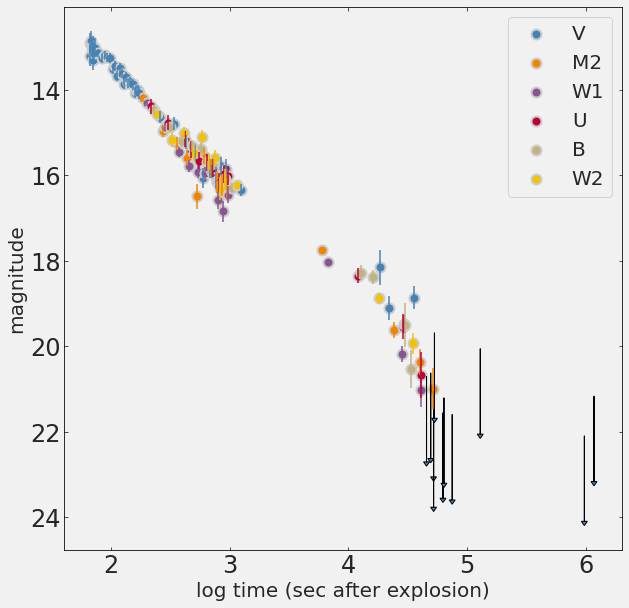

In [ ]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
#loop on every filter to plot - this will give differnt colors naturally. 
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], 
                fmt='.', ms=0,
                fcolor=None, label=None)
    
# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')

# plot the upperlimits as arrows
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k');

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
#pl.ylim(24,11.7)          
pl.gca().invert_yaxis()
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time (sec after explosion)", fontsize=20);

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows. 

## remove upper limits

In [ ]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values
#note the shape in python is flipped compared to the shape in linear algebra

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [ ]:
# make the X matrix: 2xN matrix with first column all 1's
X = np.c_[np.ones((len(x), 1)), x]


print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [ ]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " + 
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```. 
To remove the upper limits you can "broadcast" the data: in pandas that looks like 

```grbAG.loc[grbAG.upperlimit == 0]```



In [ ]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

lr.fit(X, y)
print ("best fit parameters from the sklearn LinearRegression(): " + 
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))


best fit parameters from the sklearn LinearRegression(): intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


# split training and test set (incorrectly!)

In [ ]:
x_train, x_test, y_train, y_test, s_train, s_test = x[:75], x[75:], y[:75], y[75:], s[:75], s[75:]


# Fit a line to the data (excluding the upper limits) by minimizing an objective function on the training set. test it on the test set

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [ ]:
#define utility functions

def line(x, intercept, slope):
    """ function for a line
    Input: 
      x: array-like, the independent variable
      intercept: floating point value
      slope: floating point value
    return: 
      y (array-like) values for each x value
    """
    return slope * x + intercept

def chi2(args, x, y, s):
    """ Pearson's chi squared goodness of fit test
    Requires the function line to be defined
    Input: 
      args: tuple, the slope and intercept for the line
      x: array-like, the independent variable
      y: array-like, observations for each x
      s: array-like, uncertainty on y
    Return: 
      chi squared
    """
    a, b = args
    return sum((y - line(x, a, b))**2 / s)

def Rsquare(args, x, y):
    """ Vanilla R-squared goodness of fit test
    Requires the function line to be defined
    Input: 
      args: tuple, the slope and intercept for the line
      x: array-like, the independent variable
      y: array-like, observations for each x
    Return: 
      chi squared
    """
    a, b = args
    return (1 / x.shape[0]) * sum((y - line(x, a, b))**2) / np.std(y)**2

def l1(args, x, y):
    """ L1 distance metric
    Input:
      args: tuple, the slope and intercept for the line
      x: array-like, the independent variable
      y: array-like, observations for each x
    Return: 
      L1
    """
    a, b = args
    return sum(np.abs(y - line(a, b, x)))


In [ ]:
def plotline(pars, x, color='k', symbol='-', label='model', ax=ax):
    """plots a line
    Input:
      pars: tuple - slope and intercept
      x: independent variable
      color: (string optional) color of the line, default black
      symbol: (string optional) symbol for the line plot, default is solid line
      label: (string optional) the name of the model
      ax: (pylab axis object, optional) the axis object to be used
    """  
    slope, intercept = pars
    print(slope, intercept)
    y = line(x, intercept, slope)
    ax.plot(x, y, ls=symbol, c=color, label=label)

def plotdatapoints(x_train, y_train, s_train, 
                   x_test, y_test, s_test, linepars=None):
  """plots data used for ML model split into training and test set
  Input: 
    x_train: array-like, training feature
    y_train: array-like, training target
    s_train: array-like, training uncertainty
    x_test: array-like, testing feature
    y_test: array-like, testing target
    s_test: array-like, testing uncertainty
    linepars: array-like (optional) the parameters of a line - if None no line is plotted
  """
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)
    
  #Use pl.errorbar to plot the uncertainties

  pl.errorbar(x_train, y_train, s_train, fmt='.', ms=0,
                fcolor=None, label=None, color='SteelBlue')
    
  pl.errorbar(x_test, y_test, s_test, fmt='.', ms=0,
                fcolor=None, label=None, color='IndianRed')

  pl.scatter(x_train, y_train,  
             s=100, alpha=1, linewidth=2, 
             label="training", color='SteelBlue')

  pl.scatter(x_test, y_test,
            alpha=1, s=100, linewidth=2,
           label="testing", color='IndianRed')    

  if not linepars is None:
    plotline(linepars[:2], linepars[2], ax=ax, label=linepars[3])
    

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)          
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time (sec after explosion)", fontsize=20);
  return ax



2.4697272739616185 8.664279948799948
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 45.75745016446026
        x: [ 8.664e+00  2.470e+00]
      nit: 4
      jac: [ 4.768e-07  8.583e-06]
 hess_inv: [[ 1.378e-02 -4.593e-03]
            [-4.593e-03  1.645e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.66, intercept 2.47
 R square on training set:  0.02861696532287791
 R square on test set:  0.03187874382649872


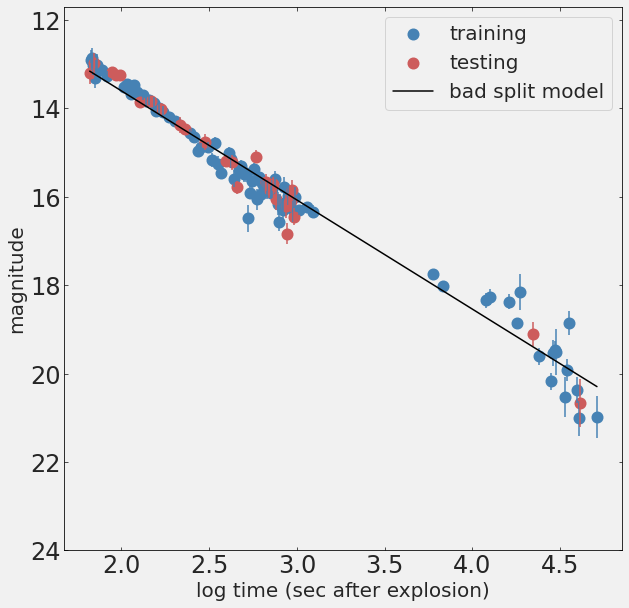

In [ ]:
# move the imports at the top!!
import scipy
from scipy.optimize import minimize

initialGuess = (10, 1)

chi2Solution = minimize(chi2, initialGuess, args=(x_train, y_train, s_train))
plotdatapoints(x_train, y_train, s_train, x_test, y_test, s_test, linepars=(*chi2Solution.x[::-1], x, "bad split model"))

print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

print(" R square on training set: ", Rsquare(chi2Solution.x, x_train, y_train))
print(" R square on test set: ", Rsquare(chi2Solution.x, x_test, y_test))

# splitting data properly

In [ ]:
# move the imports at the top!!
import sklearn
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
     x, y, s, test_size=0.25, random_state=42)



2.9612796552291334 7.501002494112149
2.4697272739616185 8.664279948799948
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 45.75745016446026
        x: [ 8.664e+00  2.470e+00]
      nit: 4
      jac: [ 4.768e-07  8.583e-06]
 hess_inv: [[ 1.378e-02 -4.593e-03]
            [-4.593e-03  1.645e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.66, intercept 2.47
R square on training set:  0.9713830346771221
R square on test set:  0.9681212561735013


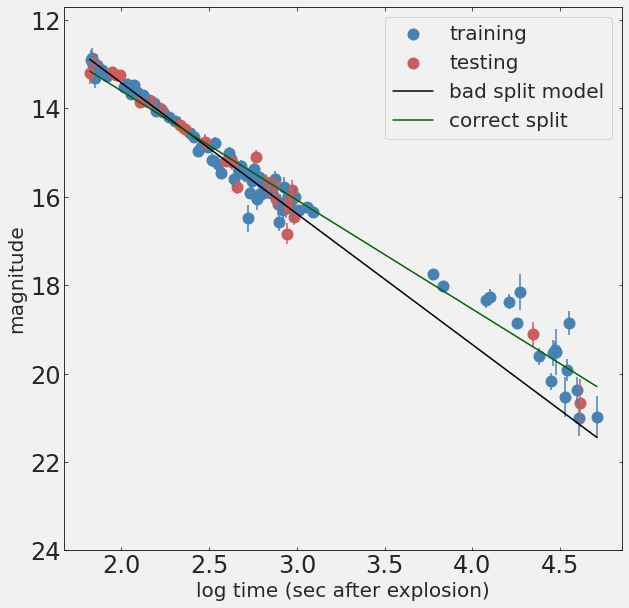

In [ ]:
ax = plotdatapoints(x_train, y_train, s_train, x_test, y_test, s_test, 
                    linepars=(*chi2Solution.x[::-1], x, "bad split model"))

initialGuess = (10, 1)

chi2Solution_goodsplit = minimize(chi2, initialGuess, args=(x_train, y_train, s_train))

plotline(chi2Solution_goodsplit.x[::-1], x, color='DarkGreen', ax=ax, label='correct split')
pl.legend()


print(chi2Solution_goodsplit)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution_goodsplit.x))

print("R square on training set: ", Rsquare(chi2Solution_goodsplit.x, x_train, y_train))
print("R square on test set: ", Rsquare(chi2Solution_goodsplit.x, x_test, y_test))

In [ ]:
Rsquaresolution

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -2394349.3981863945
        x: [-2.924e+02 -9.880e+02]
      nit: 1
      jac: [ 1.405e+03  4.408e+03]
 hess_inv: [[ 8.888e-01 -3.520e-01]
            [-3.520e-01 -1.124e-01]]
     nfev: 348
     njev: 112

2.4697272739616185 8.664279948799948
2.484059549974821 8.658389643858253


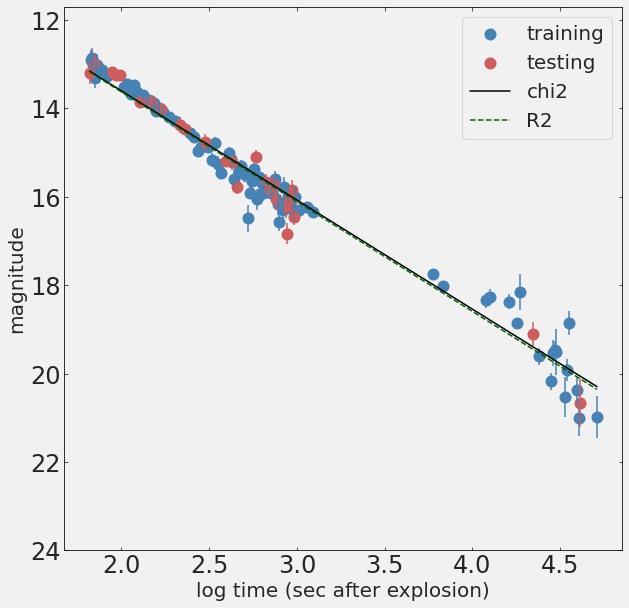

In [ ]:

initialGuess = (10, 1)

L1solution = minimize(l1, initialGuess, args=(x_train, y_train))
Rsquaresolution = minimize(Rsquare, initialGuess, args=(x_train, y_train))
ax = plotdatapoints(x_train, y_train, s_train, x_test, y_test, s_test, 
               linepars=(*chi2Solution_goodsplit.x[::-1], x, "chi2"))
plotline(Rsquaresolution.x[::-1], x, color='DarkGreen', symbol='--',
         ax=ax, label='R2')
pl.legend()

2.4697272739616185 8.664279948799948
2.511999838500434 8.582668233648741
2.511999838500421 8.582668233648771
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 45.75745016446026
        x: [ 8.664e+00  2.470e+00]
      nit: 4
      jac: [ 4.768e-07  8.583e-06]
 hess_inv: [[ 1.378e-02 -4.593e-03]
            [-4.593e-03  1.645e-03]]
     nfev: 18
     njev: 6

best fit parameters from the minimization of the chi squared: slope 8.66, intercept 2.47


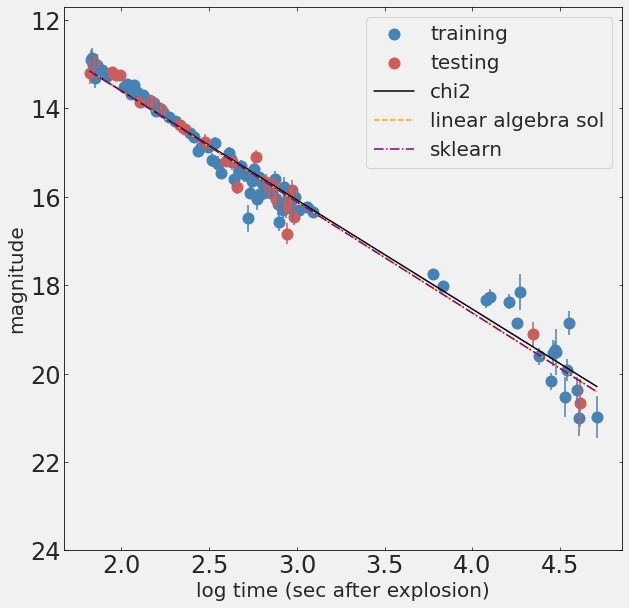

In [ ]:
ax = plotdatapoints(x_train, y_train, s_train, x_test, y_test, s_test, 
                    linepars=(*chi2Solution_goodsplit.x[::-1], x, "chi2"))


plotline(theta_best[::-1], x, color='Orange', symbol='--', 
         ax=ax, label='linear algebra sol')
plotline((lr.coef_[1], lr.intercept_), x, color='purple',  symbol='-.', 
         ax=ax, label='sklearn')
pl.legend()


print(chi2Solution_goodsplit)
print("")
print("best fit parameters from the minimization of the chi squared: " + 
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution_goodsplit.x))


2.511999838500434 8.582668233648741
2.511999838500421 8.582668233648771
2.565355662777727 8.4031235862471
2.4697272739616185 8.664279948799948


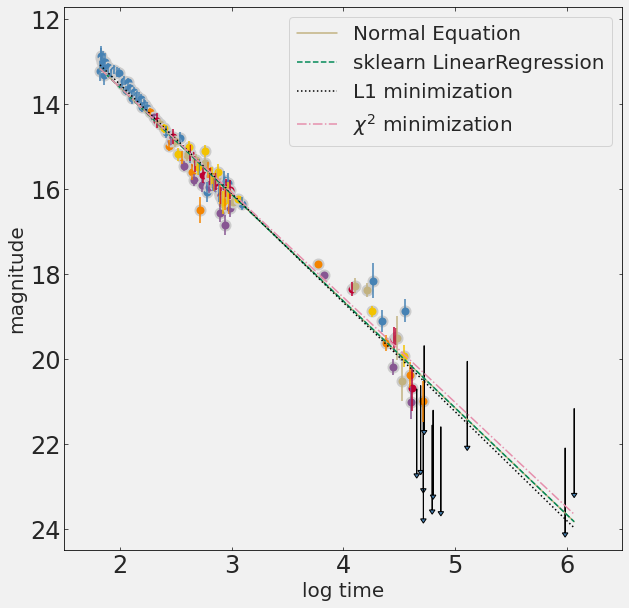

In [ ]:

ax = pl.figure(figsize=(10,10)).add_subplot(111)

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"], 
                grbAG.loc[grbAG["filter"] == f, "mag"], 
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"], fmt='.', ms=0,
                fcolor=None, label=None)
    
# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"], 
               grbAG.loc[grbAG["filter"] == f, "mag"], 
               alpha=1, s=100, linewidth=2,
               edgecolor='#cccccc', label=None)
    

# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime, 
             grbAG.loc[i].magerr, 0, 2, 
            head_width=0.05, head_length=0.1, ec='k')
    
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379', 
          '604E97', 'F6A600', 'B3446C', 
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline(theta_best[::-1], grbAG.logtime.values, 
         color='#'+colors[0], 
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,  
         color='#'+colors[2], symbol='--',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((L1solution.x), grbAG.logtime,  
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime, 
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);